Download MIDI files from https://www.reddit.com/r/datasets/comments/3akhxy/the_largest_midi_collection_on_the_internet/

In [1]:
import random
import numpy as np
import os
import joblib
import pretty_midi
from glob import glob

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

#filepaths = glob("./midi_dataset/groove/*/*/*beat_4-4.mid")
filepaths = glob("./midi_dataset/130000_Pop_Rock_Classical_Videogame_EDM_MIDI_Archive/**/*.mid", recursive=True)
#filepaths.extend(filepaths2)

print(len(filepaths))

# remove "fill" rhythms
filepaths = [path for path in filepaths if "fill" not in path]
print(len(filepaths))

119484
119467


In [16]:
import itertools

DRUM_CLASSES = [
    'Kick',
    'Snare',
    'Hi-hat closed',
    'Hi-hat open',
    'Tom low',
    'Tom mid',
    'Tom high',
    'Clap',
    'Rim'
]
NB_DRUMS = len(DRUM_CLASSES)

# one-hot vectorでドラムを表現したいので、個別に９つのドラムとして扱うのではなく、それらの可能な512の組み合わせとして扱う
DRUM_COMBINATIONS = []

for i in range(0, NB_DRUMS + 1):
    c = list(itertools.combinations(range(9), i))
    DRUM_COMBINATIONS.extend(c)
    
print(DRUM_COMBINATIONS)
NB_DRUM_COMBINATIONS = len(DRUM_COMBINATIONS)
print(NB_DRUM_COMBINATIONS)

## if you want to use reddit dataset, uncomment this
MIDI_DRUM_MAP = {
    36: 0, # Kick	Acoustic Bass Drum
    35: 0, # Kick	Bass Drum
    38: 1, # Snare	Acoustic Snare
    40: 1, # Snare	Electric Snare
    42: 2, # Hi-hat closed	Closed Hihat
    44: 3, # Hi-hat open	Pedal Hihat
    46: 3, # Hi-hat open	Open Hihat
    41: 4, # Tom low	Low floor Tom
    45: 4, # Tom low	Low Tom
    47: 5, # Tom mid	Low-mid Tom
    48: 5, # Tom mid	High-mid Tom
    43: 6, # Tom high	High Floor Tom
    50: 6, # Tom high	High Tom
    39: 7, # Clap	hand clap
    51: 8, # Rim	Ride Symbal 1
    52: 8, # Rim	Chinese Symbal
    53: 8, #  Rim	Ride Bell
    59: 8, # Rim	Ride Symbal 2
}


DRUM_MIDI_MAP  = [ # pianoroll to MIDI - reverse
    36, # 0 Kick / Bass Drum 1
    40, # 1 Snare / Electric Snare
    42, # 2 Hihat Closed
    46, # 3 Hihat Open
    47, # 4 Low Tom
    66, # 5 High Tom
    51, # 6 Cymbal
    63, # 7 Clap / Cowbell
    39  # 8 Rim / Side Stick
]

PIANO_MIDI_INST = 1  #  accoustic piano - General MIDI規格で指定されるピアノのチャンネル
BASS_MIDI_INST  = 39 # accoustic bass 

RESOLUTION  = 4 # separate quater into 4  = 16 notes per bar

NB_BARS = 2 

LEN_SEQ = RESOLUTION * 4 * NB_BARS # length of drumloops in training data - 2 bars


NB_NOTES = 128
INDEX_NOTEOFF = NB_NOTES + 0
INDEX_REST = NB_NOTES + 1
NB_NOTES_TOTAL = NB_NOTES + 2 # 130 = notes / note off / rest



[(), (0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (4, 5), (4, 6), (4, 7), (4, 8), (5, 6), (5, 7), (5, 8), (6, 7), (6, 8), (7, 8), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6), (0, 1, 7), (0, 1, 8), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 2, 6), (0, 2, 7), (0, 2, 8), (0, 3, 4), (0, 3, 5), (0, 3, 6), (0, 3, 7), (0, 3, 8), (0, 4, 5), (0, 4, 6), (0, 4, 7), (0, 4, 8), (0, 5, 6), (0, 5, 7), (0, 5, 8), (0, 6, 7), (0, 6, 8), (0, 7, 8), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 2, 6), (1, 2, 7), (1, 2, 8), (1, 3, 4), (1, 3, 5), (1, 3, 6), (1, 3, 7), (1, 3, 8), (1, 4, 5), (1, 4, 6), (1, 4, 7), (1, 4, 8), (1, 5, 6), (1, 5, 7), (1, 5, 8), (1, 6, 7), (1, 6, 8), (1, 7, 8), (2, 3, 4), (2, 3, 5), (2, 3, 6), (2, 3, 7), (2, 3, 8), (2, 4, 5), (2, 4, 6), (2, 4, 7), (2, 4, 8), (2, 5, 6), (2, 

In [2]:


#一小節以上休符がつづいてないか確認
def find_one_bar_rest(onsets, beats): # onsets / beats in secods
    for onset1, onset2 in zip(onsets[:-1], onsets[1:]):
        margin = onset2 - onset1
        
        beat_index = np.abs(beats - onset1).argmin()
        if beat_index < len(beats) - 4:
            bar_length = beats[beat_index + 4] - beats[beat_index] # one bar
            if bar_length < margin: # too long consecutive rests
                return True
    return False

In [3]:
# skipずつ飛ばして nb_bars小節のかたまりを３つのトラックからあつめる
def get_all_segments(piano, bass, drum, nb_bars = 2, skip = 1):
    nb_grid_in_bar = RESOLUTION * 4 # 2 x 16 notes
    
    min_length = min(piano.shape[1], bass.shape[1], drum.shape[1])
    min_bars = int(min_length / nb_grid_in_bar)
    
    tracks = []
    for i in range(0, min_bars, skip):
        p = piano[:,i * nb_grid_in_bar : (i + nb_bars) * nb_grid_in_bar]
        b = bass[:, i * nb_grid_in_bar : (i + nb_bars) * nb_grid_in_bar]
        d = drum[:, i * nb_grid_in_bar : (i + nb_bars) * nb_grid_in_bar]
        tracks.append([p, b, d])
        
    return tracks

# ピアノ、ベース、ドラムのトラックが複数ある場合、それぞれからひとつずつ選んで組み合わせをつくる
def get_all_combinations(piano_rolls, bass_rolls, drum_rolls):
    matrices = []
    for piano_roll in piano_rolls:
        for bass_roll in bass_rolls:
            for drum_roll in drum_rolls:
                segments = get_all_segments(piano_roll, bass_roll, drum_roll)
                matrices.extend(segments)
    return matrices

In [69]:

import matplotlib.pyplot as plt
%matplotlib inline

# 表示用
def plot_drum_matrix(a, length=1000):
    if a is not None:
        #a = np.transpose(np.squeeze(a))
        plt.figure(figsize=(5, 10))
        plt.matshow(a[:,:length])
        plt.show()  
        
# ドラムロール
def get_drum_roll(instrument, matrix_sf):
    end_time = instrument.get_end_time()
    drum_roll_tmp = np.zeros((NB_DRUMS, int(matrix_sf*end_time)+1)) # 128 notes, 1 note off, 1 reset
    
    # まずは素直に　９ｘ時間のマトリクスを作る
    for note in instrument.notes:
        if note.pitch in MIDI_DRUM_MAP.keys():
            drum_pitch = MIDI_DRUM_MAP[note.pitch]
            drum_roll_tmp[drum_pitch, int(note.start*matrix_sf)] = 1 

    # 9つのドラムの組み合わせを
    drum_roll = np.zeros((NB_DRUM_COMBINATIONS, int(matrix_sf*end_time)+1)) # 512 combinations including rest
    for i in range(drum_roll_tmp.shape[1]):
        index = DRUM_COMBINATIONS.index(tuple(list(np.nonzero(drum_roll_tmp[:, i])[0])))
        drum_roll[index, i] = 1
            
    assert(np.count_nonzero(drum_roll, axis=0).all() == 1)    
    return drum_roll

# piano bass roll
def get_piano_roll(instrument, matrix_sf, is_drum = False):
    # pianorollのサイズを決定
    end_time = instrument.get_end_time()
    piano_roll = np.zeros((NB_NOTES_TOTAL, int(matrix_sf*end_time)+1)) # 128 notes, 1 note off, 1 reset
    
    # initialize with rest
    piano_roll[INDEX_REST, :] = 1 
    
    note_ons, note_offs = [], []
    for note in instrument.notes:
        if int(note.start*matrix_sf) not in note_ons: # 和音の場合はどれかひとつ            
            piano_roll[INDEX_REST, int(note.start*matrix_sf)] = 0
            piano_roll[note.pitch, int(note.start*matrix_sf)] = 1 
            note_ons.append(int(note.start*matrix_sf))        
            note_offs.append(int(note.end*matrix_sf))     
                    
    note_ons = sorted(note_ons)
    note_offs = sorted(note_offs)
    
    # note offはnote onとnote onの間に最大ひとつだけ 
    # noteはoffがくるかつぎのnote onがくるまで続く
    for on1, on2 in zip(note_ons[:-1], note_ons[1:]):
        for i in range(on1, on2):
            if i in note_offs and i not in note_ons:
                piano_roll[INDEX_NOTEOFF, i] = 1
                piano_roll[INDEX_REST, i] = 0
                continue
                
    assert(np.count_nonzero(piano_roll, axis=0).all() == 1)    
    return piano_roll

# 学習データ用のpiano rollをget
# ピアノ、ベース、ドラム、それぞれのピアノロールを取得して、その３つを組み合わせて学習データとする
def get_track_rolls(path):

    # load midi file
    try:
        pm = pretty_midi.PrettyMIDI(path)
    except:
        return []
    
    # check time signature
    if (len(pm.time_signature_changes) > 0 and pm.time_signature_changes[0].numerator == 4
                 and pm.time_signature_changes[0].denominator == 4) is False:
        return []
    
    # get timiming of quater notes
    beats = pm.get_beats()
        
    beats_16th = []
    for beat1, beat2 in zip(beats[:-1], beats[1:]):
        note16th = (beat2 - beat1)/4.
        for i in range(4):
            beats_16th.append(beat1 + i * note16th)
    
    # tracks
    piano_tracks = []
    bass_tracks = []
    drum_tracks = []
    for instrument in pm.instruments:
        # 休符が続いてないか確認
        onsets = list(instrument.get_onsets())
        onsets.insert(0, 0)  # 最初と最後に長い無音が入ってないか確認
        onsets.append(pm.get_end_time())
        if find_one_bar_rest(onsets, beats) is False:
            if instrument.program in range(0, 32):
                piano_tracks.append(instrument)
            if instrument.program in range(32, 40):
                bass_tracks.append(instrument)
            if instrument.is_drum == True:  # use drum tracks only            
                drum_tracks.append(instrument)
    
    # invlid 
    if (len(piano_tracks) > 0 and len(bass_tracks) > 0 and len(drum_tracks) > 0) is False:
        return []

    #テンポチェンジがあるものは一旦無視 ignore midi files containing tempo changes
    if len(pm.get_tempo_changes()[0]) != 1:
        return []    
    
    # 
    tempo = pm.get_tempo_changes()[1][0]
    matrix_sf = 1.0 / ((60.0/tempo)/4.0)
    
    # get actual matrices
    piano_rolls = []
    bass_rolls = []
    drum_rolls = []
    
    for instrument in piano_tracks:
#         pr = instrument.get_piano_roll(matrix_sf) # バグがある？？
#         plot_drum_matrix(pr)
        piano_roll = get_piano_roll(instrument, matrix_sf)
        piano_rolls.append(piano_roll)
        
    for instrument in bass_tracks:
        bass_roll = get_piano_roll(instrument, matrix_sf)
        bass_rolls.append(bass_roll)

    for instrument in drum_tracks:
        drum_roll = get_drum_roll(instrument, matrix_sf)
        drum_rolls.append(drum_roll)
    
    assert(len(piano_rolls) > 0 and len(bass_rolls) > 0 and len(drum_rolls) > 0)
    
    matrices = get_all_combinations(piano_rolls, bass_rolls, drum_rolls)
    return matrices


In [18]:
from tqdm import tqdm_notebook
from joblib import Parallel, delayed

r = Parallel(n_jobs=-1, verbose=3)(delayed(get_track_rolls)(path) for path in filepaths[:10000]) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 522 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 1098 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1461 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 2074 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 3034 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 3965 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 4573 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 5590 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 7062 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 8662 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.5min finished


In [70]:
# list of MIDI files containing piano, bass and drum
piano_matrices = []
bass_matrices = []
drum_matrices = []

for matrices in r:
    if type(matrices) is list and len(matrices) > 0:
        for m in matrices:
            if m[0].shape[1] == LEN_SEQ and m[1].shape[1] == LEN_SEQ and m[2].shape[1] == LEN_SEQ:
                piano_matrices.append(m[0])
                bass_matrices.append(m[1])
                drum_matrices.append(m[2])

# convert to np.array
assert(len(piano_matrices) == len(bass_matrices) and len(drum_matrices) == len(bass_matrices))
piano_matrices = np.array(piano_matrices)
print(piano_matrices.shape)
bass_matrices = np.array(bass_matrices)
print(bass_matrices.shape)
drum_matrices = np.array(drum_matrices)
print(drum_matrices.shape)

(46706, 130, 32)
(46706, 130, 32)
(46706, 512, 32)


In [62]:
import csv 

# データの保存
# with open('midi_dataset/13000_trio_files.csv', 'w') as f:
#     writer = csv.writer(f)
#     writer.writerows(valid_filepaths)

np.savez("midi_dataset/trio_matrices.npz", piano_matrices=piano_matrices,  bass_matrices=bass_matrices, drum_matrices=drum_matrices)

sample: 0
piano


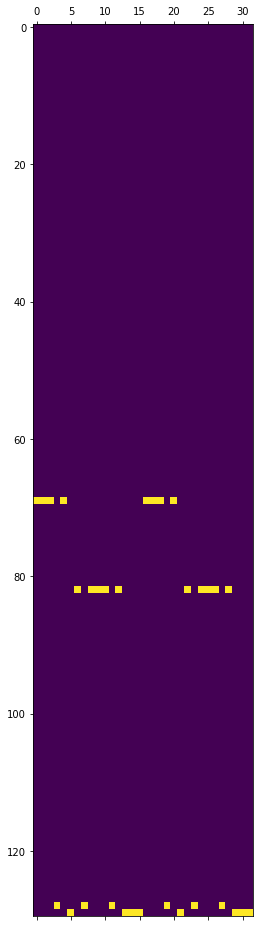

bass


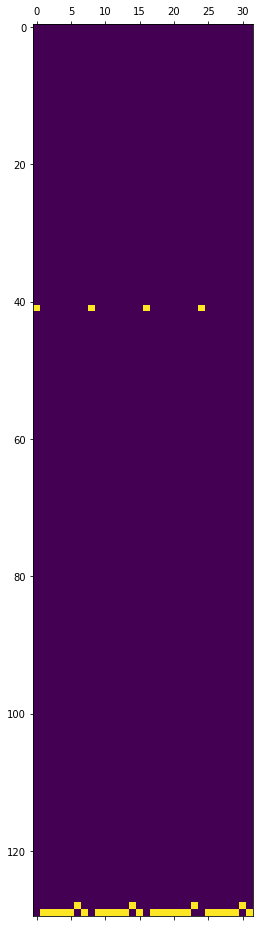

drum


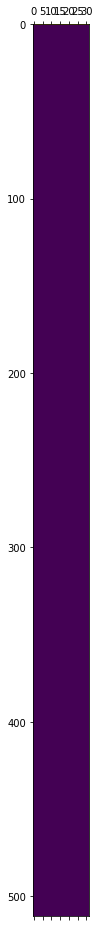



sample: 1
piano


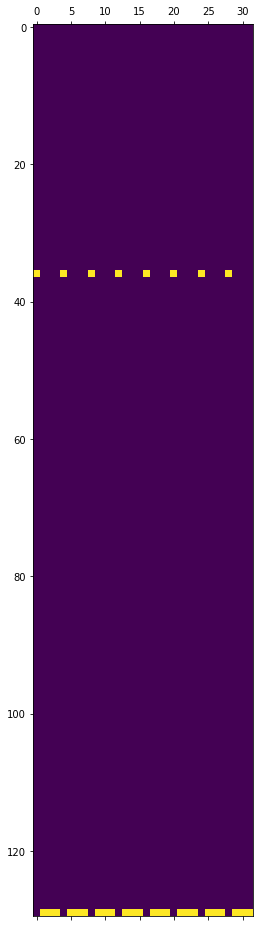

bass


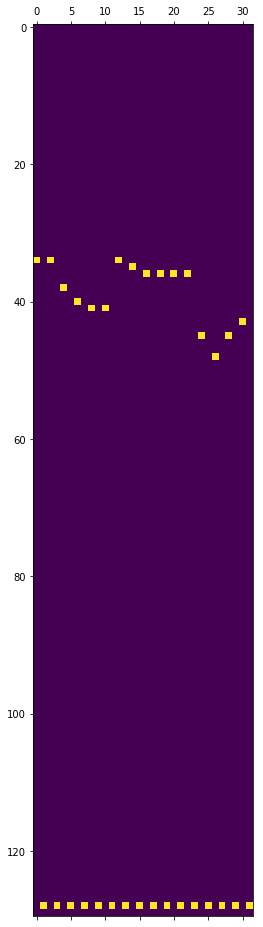

drum


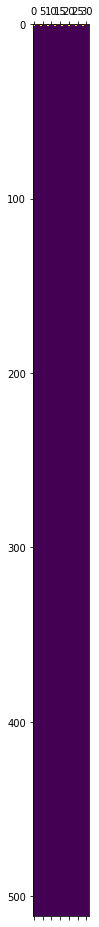

In [72]:
# ためしに表示
for i in range(2):
    print("sample:",i)
    
    index = random.choice(range(len(piano_matrices)))
    print("piano")
    plot_drum_matrix(piano_matrices[index])    
    print("bass")
    plot_drum_matrix(bass_matrices[index])    
    print("drum")
    plot_drum_matrix(drum_matrices[index])
    
    print()
    print()

## Restore preprocessed data

In [2]:
import numpy as np

piano_matrices = np.load("midi_dataset/trio_matrices.npz")['piano_matrices']
bass_matrices = np.load("midi_dataset/trio_matrices.npz")['bass_matrices']
drum_matrices = np.load("midi_dataset/trio_matrices.npz")['drum_matrices']
                         

In [9]:
np.argmax(piano_matrices[0],axis=0)

array([129, 129,  57, 129,  57,  60, 129, 129, 129, 129, 129, 129, 129,
       129, 129, 128,  55, 128,  62, 129,  62,  62, 129, 128,  62, 129,
        62, 129,  62, 129,  62, 129])

## Matrix data -> MIDI Playback

If you haven't installed `fluidsynth`, try `sudo apt-get install fluidsynth`.

音の再生には `fluidsynth` が必要。Macではbrew https://brew.sh/index_ja をインストールして
`brew install https://raw.githubusercontent.com/Homebrew/homebrew-core/34dcd1ff65a56c3191fa57d3dd23e7fffd55fae8/Formula/fluid-synth.rb`
が早い。*最新の`fluidsynth`はMacでは`pyfluidsynth`と相性が悪いので注意！* Ubntuでは  `sudo apt-get install fluidsynth`

# 注意: たまになぜかオーディオがホワイトノイズになる！！なぜ？？

In [53]:
import pretty_midi
import random
from IPython.display import Audio
import math

def play_trio_matrix(piano, bass, drum, tempo=120.0):
    # generate audio - 各トラックをオーディオに変換
    piano_audio = get_audio_from_matrix(piano, PIANO_MIDI_INST, tempo=tempo)
    bass_audio = get_audio_from_matrix(bass, BASS_MIDI_INST, tempo=tempo)
    drum_audio = get_audio_from_matrix(drum, -1, is_drum=True, tempo=tempo)

    # 長さを揃える
    length = max(piano_audio.shape[0], bass_audio.shape[0], drum_audio.shape[0])
    piano_audio = np.pad(piano_audio, (0, length - piano_audio.shape[0]), 'constant', constant_values=(0))
    bass_audio = np.pad(bass_audio, (0, length - bass_audio.shape[0]), 'constant',  constant_values=(0))
    drum_audio = np.pad(drum_audio, (0, length - drum_audio.shape[0]), 'constant',  constant_values=(0))
    
    # ミックス
    audio_data = 0.33 * (piano_audio + bass_audio + drum_audio)
    display(Audio(audio_data, rate=44100))
    return audio_data

def get_audio_from_matrix(onsets, midi_inst, is_drum = False, tempo=120.):
    pm = pretty_midi.PrettyMIDI(initial_tempo=tempo) # midi object
    
    if is_drum:
        pm_inst = pretty_midi.Instrument(0, is_drum=True) # midi instrument  ドラム
    else:
        pm_inst = pretty_midi.Instrument(midi_inst, is_drum=False) # midi instrument　それ以外
    
    # グリッドの時間幅を計算
    timestep = (60./tempo) / 4. # duration of a 16th note
    offset_unit = timestep / 2. # max offset == 32nd note
    
    # matrix  -> sequence
    sequence = np.argmax(onsets, axis=0)
    
    note_start = 0
    current_note = INDEX_REST #直前のnote onのピッチ
    
    velocity = 100

    def add_note(note_number, velocity, note_start, note_end):
        note = pretty_midi.Note(velocity=velocity, pitch=note_number, start=note_start, end=note_end)
        pm_inst.notes.append(note)
    
    # ドラム
    if is_drum:
        for position, note_index in enumerate(sequence):
            assert note_index < len(DRUM_COMBINATIONS)
            drums = DRUM_COMBINATIONS[note_index]
            for drum in drums:
                assert drum < len(DRUM_MIDI_MAP)
                note = DRUM_MIDI_MAP[drum]
                add_note(note, velocity,  timestep * position, timestep * position + 0.5) # この場合 durationは関係ないので適当に
    else: # ピアノ/ベース
        for position, note in enumerate(sequence):
            # note offがきた場合
            if note == INDEX_NOTEOFF and current_note < INDEX_NOTEOFF: # 直前のnote onがnote offされてない
                add_note(note, velocity, note_start, timestep * position)
                current_note = INDEX_NOTEOFF # note offすべきnoteをリセット

            # note onがきた場合
            if note < INDEX_NOTEOFF:
                if current_note < INDEX_NOTEOFF: # 直前のnote onがnote offされてない
                    add_note(note, velocity, note_start, timestep * position)
                    current_note = INDEX_NOTEOFF # note offすべきnoteをリセット
                else: # 直前のnote onがなければ、note onの情報をストア
                    current_note = note
                    note_start = timestep * position
            
    # channelを追加
    pm.instruments.append(pm_inst)

    # midi -> audio
    audio_data = pm.fluidsynth()
    return audio_data


# test

for _ in range(5):
    index = random.randint(0, len(piano_matrices))
    piano = piano_matrices[index]
    bass = bass_matrices[index]
    drum = drum_matrices[index]
    audio_data = play_trio_matrix(piano, bass, drum, tempo=120.)



(512, 32)
[[0. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0]


(512, 32)
[[0. 1. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[11  0  3  0 18  0 12  0 11  0  3  0 47  0  3  0 11  0  3  0 19  0  3  0
 11  0  3  0 19  0  3  0]


(512, 32)
[[0. 1. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[ 1  0  4  0 19  0  4  0 12  0  4  0 19  0  4  0 12  0  4  0 19  0  4  0
 12  0  4  0 19  0  4  1]


(512, 32)
[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[1 0 0 0 2 0 0 0 1 0 0 0 2 0 0 0 1 0 0 0 2 0 0 0 1 0 1 0 2 0 0 0]


(512, 32)
[[0. 1. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[11  0 30  0 29  0 58  0  3  1 30  0 29  0 35  0 11  0 30  0 29  0 58  0
  3  1 30  0 29  0 35  0]


In [ ]:
for i, genre in enumerate(GENRES):
    print(genre)
    d = np.array([d  for d, g in zip(matrices_onsets, matrices_genres) if g == i])
    o = np.array([d  for d, g in zip(matrices_offsets, matrices_genres) if g == i])
    
    
    print("    average onsets")
    plot_drum_matrix(np.mean(d, axis=0))
    
    print("    std")
    plot_drum_matrix(np.std(d, axis=0))
    #print(np.std(d, axis=0))
    
    print("    average offsets")
    plot_drum_matrix(np.mean(o, axis=0))
    print("    std offsets")
    plot_drum_matrix(np.std(o, axis=0))
    
    index = random.randint(0, d.shape[0])
    print(o[index].shape)
    play_drum_matrix(d[index], offsets=o[index])
    
    index = random.randint(0, d.shape[0])
    print(o[index].shape)
    play_drum_matrix(d[index], offsets=o[index])